In [1]:
import data_helpers
import os
import pandas as pd

dataframes = {}
ls = os.listdir(os.getcwd() + "/Dataframes/All")
for file in ls:
    if '.csv' in file:
        df = pd.read_csv(os.getcwd() + "/Dataframes/All/" + file, encoding='utf-8', engine='python')
        print(">>> {}:".format(file))
        print(df.columns.tolist(), '\n')
        dataframes[file.replace(".csv", "")] = df

>>> All-Test.csv:
['Unnamed: 0', 'text-rel', 'token', 'ActionName', 'Capability'] 

>>> All-Dev.csv:
['Unnamed: 0', 'text-rel', 'token', 'ActionName', 'Capability'] 

>>> All-Train.csv:
['Unnamed: 0', 'text-rel', 'token', 'ActionName', 'Capability'] 



In [2]:
dataframes['All-Train'].head()

,Unnamed: 0,text-rel,token,ActionName,Capability
0,0,ScanBox performs keylogging of users when they...,performs,-,other
1,1,an attacker perform reconnaissance and key log...,perform,-,other
2,2,tracking files and drives present on the victi...,tracking,-,other
3,3,it being a command and control destination for...,being,-,command_and_control
4,4,the e-mails contain links to websites hosting ...,contain,-,infection_propagation


In [3]:
'''
Join Dev with Test, because why bother?
'''

for cat in dataframes.keys():
    if 'Test' in cat:
        new_df = dataframes[cat]
        for ccat in dataframes.keys():
            if 'Dev' in ccat and ccat.replace("Dev", "Test") == cat:
#                 new_df = pd.concat([new_df, dataframes[ccat]], sort=False)
                new_df = new_df.append(dataframes[ccat], ignore_index=True)
                dataframes[cat] = new_df
                
dataframes = {cat : dataframes[cat] for cat in dataframes if 'Dev' not in cat}

In [4]:
dataframes.keys()

dict_keys(['All-Test', 'All-Train'])

In [5]:
from tokenizer import TheTokenizer
my_tokenizer = TheTokenizer(stem=False, lem=False, stopword=False)

In [6]:
'''
Process data from sentences to list of words:
- remove punctuation
- convert to lowercase
- split by whitespace to get list
- stem or lemmatize
- remove stopwords
- remove one-char words?
- remove words longer than 30 (probably some hashes)
'''

import re
from nltk import word_tokenize, pos_tag     
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

for cat in dataframes.keys():
    df = dataframes[cat]
    print(">>> {}".format(cat))
    cols = df.columns.tolist()
    for c in cols:
        if 'text' in c and 'token' not in c and 'processed' not in c:
            
            data = df[c]
#             print(data[0:1]) 
#(BEFORE)
            
            data = data.apply(lambda x : re.sub(r'[,\[\]\(\)"’]', '', x))
            data = data.apply(lambda x : x.lower())
            data = data.apply(lambda x : x.split())
            
            data = data.apply(lambda tokens : [my_tokenizer.stem_token(t) for t in tokens])
#             data = data.apply(lambda tokens : [my_tokenizer.lemmatize_token(t, pos) for t, pos in pos_tag(tokens)])
            
            data = data.apply(lambda tokens : [t for t in tokens if t not in stopwords])
        
            data = data.apply(lambda tokens : ['hash-code' if len(t) >= 31 else t for t in tokens])
            data = data.apply(lambda tokens : [t for t in tokens if len(t) > 1 and len(t) <= 20])
            
            df['{}-processed'.format(c)] = data.apply(lambda x : ' '.join(x))

#             print(data[0:1])
#(AFTER)


>>> All-Test
>>> All-Train


Komentarz NLP Stanford to Stemming vs Lemmatization:
    https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [7]:
'''
Attempt to replace some of very-unique words, such as file name, URL... 
(unfortunately not all are replaced, example: some long hashes and codes),
as well as remove YEAR (four digits)
'''

from data_helpers import clean_dataframe

print("Data cleaning examples:")
for cat in dataframes.keys():
    df = dataframes[cat]
    print('token' in df.columns)
    print('\n', df.at[0, 'text-rel-processed'])
    df = clean_dataframe(df)
    dataframes[cat] = df
    print(df.at[0, 'text-rel-processed'])

Data cleaning examples:
True

 attack obtain access specif system interest compromis organ
attack obtain access specif system interest compromis organ
True

 scanbox perform keylog user visit compromis websit
scanbox perform keylog user visit compromis websit


In [8]:
'''
Create -tokens columns (list of words)
'''

for cat in dataframes.keys():
    df = dataframes[cat]
    cols = df.columns.tolist()
    for c in cols:
        if 'processed' in c:
            data = df[c]
            data = data.apply(lambda x : x.split())
            label = c.replace('processed', 'tokens')
            df[label] = data

In [10]:
def dummy(doc):
    return doc

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy
)

'''
Count unique words in all datasets after we processed them into tokens.
Compare -relations and -neighbours features.
What is the size of BOW?
'''

for cat in dataframes.keys():
    print("\n>>> {}".format(cat))
    df = dataframes[cat]
    
    print("\nModel z relacjami:")
    X_counts = vectorizer.fit_transform(df['text-rel-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("Liczba dokumentów: {x}".format(x=X_counts.shape[0]))
    print("Rozmiar wektora bag-of-words {x}".format(x=X_counts.shape[1]))
    
    if 'Test' in cat:
        df_joined = df
        for ccat in dataframes.keys():
            if ccat.replace('Train', 'Test') == cat:
                df_joined = df_joined.append(dataframes[ccat], ignore_index=True)
                
                # Łączymy dataframe'y treningowe i testowe aby pokazać, że reprezentacja BOW
                # nie przyniesie 100% rezultatów - występują słowa które są w Train i nie ma ich w Test lub na odwrót
                print("\n>>> Połączenie {} + {}:".format(cat, ccat))
                X_counts = vectorizer.fit_transform(df_joined['text-rel-tokens'])
                print("Relacyjnie: {x}".format(x=X_counts.shape[1]))
                
                break


>>> All-Test

Model z relacjami:
Liczba dokumentów: 237
Rozmiar wektora bag-of-words 556

>>> Połączenie All-Test + All-Test:
Relacyjnie: 556

>>> All-Train

Model z relacjami:
Liczba dokumentów: 3348
Rozmiar wektora bag-of-words 2957


W arkuszu kalkulacyjnym możemy zobaczyć jak redukował się rozmiar BOW po przetworzeniu tekstu.
https://docs.google.com/spreadsheets/d/1KUDvUCe77z-SJ9EKlfW-axWSYfTmHRG9v59b3BqvKmY/edit?usp=sharing

In [16]:
from data_helpers import get_top_occuring_words

'''
Show top occuring words found by our vectorizer.
We get words such as 'malwar' because we applied stemming to our datasets.
'''

how_many_words = 20
for cat in dataframes.keys():
    print("\n>>> {}".format(cat))
    df = dataframes[cat]
    
    print("\nModel z relacjami:")
    X_counts = vectorizer.fit_transform(df['text-rel-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("\tbag-of-words: {x}".format(x=X_counts.shape[1]))
    
    vocab = list(map(lambda x : [len(x), x], sorted(vectorizer.vocabulary_.keys(), key=lambda x : -1*len(x))))
    print("\t- longest words:")
    print(vocab[:how_many_words])
    print("\t- shortest words:")
    print(vocab[-how_many_words:])
    
    temp_df = df
    temp_df['label'] = temp_df['ActionName']
    result = get_top_occuring_words(X_counts, 10, vectorizer, df)
    
    print("\n\t TOP:\n\t>>>ActionName:")
    
    for entry in result:
        print(entry[0])
        print(entry[1])
        
    temp_df['label'] = temp_df['Capability']
    result = get_top_occuring_words(X_counts, 10, vectorizer, df)
    
    print("\n\t TOP:\n\t>>>Capability:")
    
    for entry in result:
        print(entry[0])
        print(entry[1])



>>> All-Test

Model z relacjami:
	bag-of-words: 556
	- longest words:
[[19, 'command-and-control'], [16, 'man-in-the-middl'], [16, 'attacker-control'], [15, 'privilege-escal'], [13, 'liveupdate.ex'], [13, 'self-destruct'], [13, 'doublefantasi'], [13, 'some-variable'], [13, 'cve-2012-0158'], [13, 'cve-2014-1761'], [12, 'intermediari'], [12, 'equationdrug'], [12, 'mediasoft.ex'], [11, 'malware-rel'], [11, 'system-path'], [11, 'shellexecut'], [11, 'vietnamese-'], [11, 'windows-bas'], [11, 'architectur'], [10, 'self-delet']]
	- shortest words:
[[3, 'etc'], [3, 'atm'], [3, 'add'], [3, 'rat'], [3, 'pdf'], [3, 'ssl'], [3, 'ftp'], [3, 'rtf'], [3, 'rar'], [2, 'os'], [2, 'vf'], [2, 'dn'], [2, 'ha'], [2, 'ip'], [2, 'wa'], [2, 'go'], [2, 'pc'], [2, 'c2'], [2, '20'], [2, 'ic']]

	 TOP:
	>>>ActionName:
-
[('server', 27.0), ('c&c', 17.0), ('infect', 17.0), ('malwar', 16.0), ('system', 15.0), ('file', 15.0), ('attack', 14.0), ('thi', 14.0), ('data', 13.0), ('use', 12.0)]
File
[('file', 13.0), ('execu

In [23]:
dataframes['All-Train'].drop(['label'], axis=1)

,Unnamed: 0,text-rel,token,ActionName,Capability,text-rel-processed,text-rel-tokens
0,0,ScanBox performs keylogging of users when they...,performs,-,other,scanbox perform keylog user visit compromis we...,"[scanbox, perform, keylog, user, visit, compro..."
1,1,an attacker perform reconnaissance and key log...,perform,-,other,attack perform reconnaiss key log visitor comp...,"[attack, perform, reconnaiss, key, log, visito..."
2,2,tracking files and drives present on the victi...,tracking,-,other,track file drive present victim machin,"[track, file, drive, present, victim, machin]"
3,3,it being a command and control destination for...,being,-,command_and_control,command control destin malwar,"[command, control, destin, malwar]"
4,4,the e-mails contain links to websites hosting ...,contain,-,infection_propagation,e-mail contain link websit host scanbox,"[e-mail, contain, link, websit, host, scanbox]"
5,5,Both backdoors were dropped from malicious doc...,were dropped,Network,other,backdoor drop malici document built util tran ...,"[backdoor, drop, malici, document, built, util..."
6,6,backdoor HTTP communicates via to a hard-coded...,communicates,-,other,backdoor http commun via hard-cod command cont...,"[backdoor, http, commun, via, hard-cod, comman..."
7,7,this change decrease detection,decrease,-,other,thi chang decreas detect,"[thi, chang, decreas, detect]"
8,8,sent a spear phish email to a Taiwanese govern...,sent,Network,infection_propagation,sent spear phish email taiwanes govern ministri,"[sent, spear, phish, email, taiwanes, govern, ..."
9,9,The exploit document dropped the HIGHTIDE back...,dropped,-,-,exploit document drop hightid backdoor,"[exploit, document, drop, hightid, backdoor]"


{0: 0, 1: 1, 2: 2, 3: 3}
{0: 0, 1: 1, 2: 2, 3: 3}
{0: 0, 1: 1, 2: 2, 3: 3}
{0: 0, 1: 1, 2: 2, 3: 3}


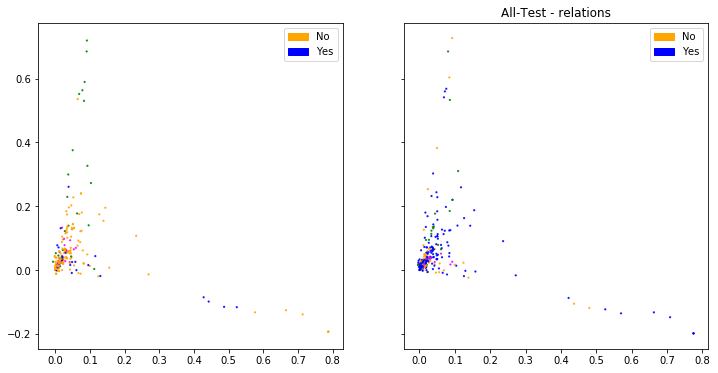

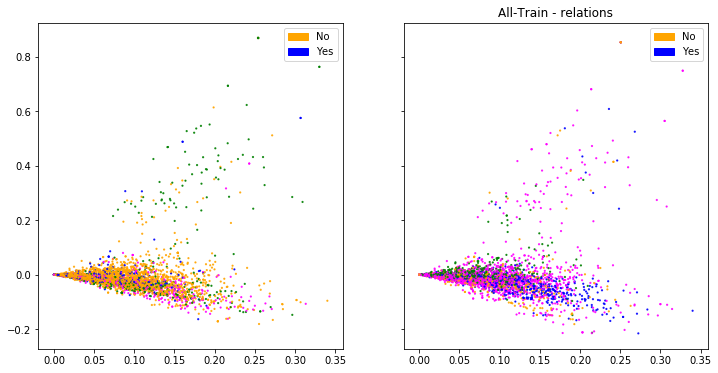

In [41]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

'''
Display PCA analysis results for the vectorizer above.
'''

def plot_LSA(test_data, test_labels, ax, savepath="PCA_demo.csv", plot=True):
        
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        print(color_mapper)
        
        colors = ['orange','blue', 'green', 'magenta']
        
        if plot:
            ax.scatter(lsa_scores[:,0], lsa_scores[:,1], s=1.5, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='No')
            green_patch = mpatches.Patch(color='blue', label='Yes')
            ax.legend(handles=[red_patch, green_patch], prop={'size': 10})

for cat in dataframes.keys():

    df = dataframes[cat]
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

    labels = df['ActionName'].astype("category").cat.codes.tolist()
    X_counts = vectorizer.fit_transform(df['text-rel-tokens'])
    plot_LSA(X_counts, labels, ax1)
    ax2.set_title("{} - relations".format(cat))
    
    labels = df['Capability'].astype("category").cat.codes.tolist()
    X_counts = vectorizer.fit_transform(df['text-rel-tokens'])
    plot_LSA(X_counts, labels, ax2)
    ax2.set_title("{} - relations".format(cat))
      


In [39]:
'''
Take another try with TF IDF vectorizer
for min_df = 0.1 we get only words common for both classes, such as 'file', 'data', 'malwar' ...
- min_df = 0.05 is quite better, but doesn't show differences neither

'''

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    max_df=0.05
)

In [40]:
for cat in dataframes.keys():
    print("\n>>> {}".format(cat))
    df = dataframes[cat]
    
    print("\nModel z relacjami:")
    X_counts = vectorizer.fit_transform(df['text-rel-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, 10, vectorizer, df)
    for entry in result:
        print(entry[0])
        print(entry[1])


>>> All-Test

Model z relacjami:
bag-of-words: 541
Other
[('exfiltr', 5.009274939260849), ('log', 4.559539070766948), ('instal', 4.118952664947478), ('access', 3.4197151587067065), ('sent', 2.8086134344579228), ('provid', 2.7427034613985493), ('machin', 2.691306092974241), ('user', 2.681702235921735), ('grayfish', 2.679890014877197), ('ssh', 2.5918518990520587)]
command_and_control
[('c2', 3.6751242930356445), ('report', 2.980076774560051), ('reach', 2.0), ('sent', 1.9713606681068296), ('configur', 1.9395941759125304), ('command-and-control', 1.7086038330028086), ('send', 1.5490598726574223), ('download', 1.1891720958268472), ('ip', 1.0999246353289607), ('address', 1.0458718059703105)]
-
[('delet', 2.5492342492574895), ('process', 2.34953775561889), ('copi', 2.3007522229579784), ('creat', 2.1766904339254376), ('administr', 2.0753897015403004), ('download', 2.034739367630224), ('run', 1.7657113157437883), ('system-path', 1.6466325480454138), ('eve-file', 1.590158046771435), ('payload',

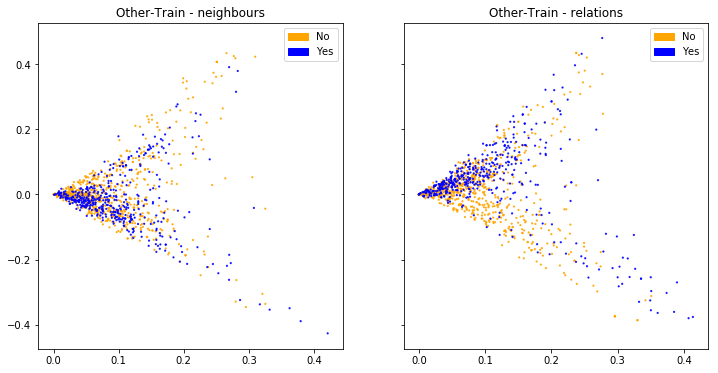

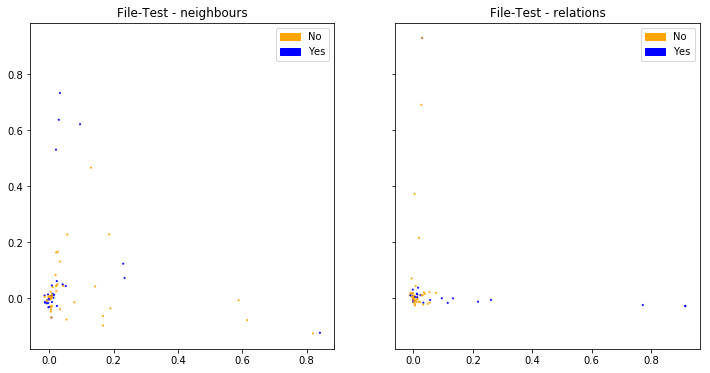

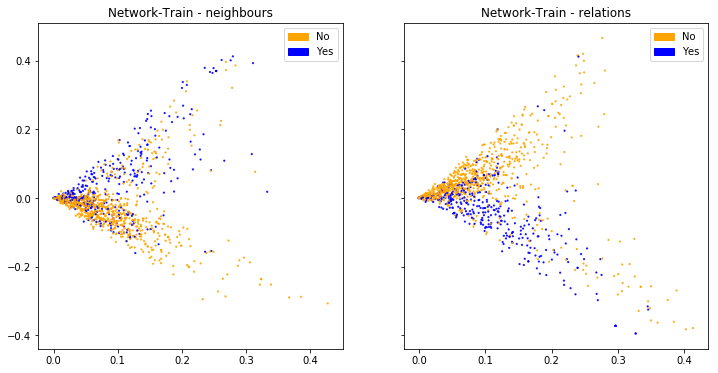

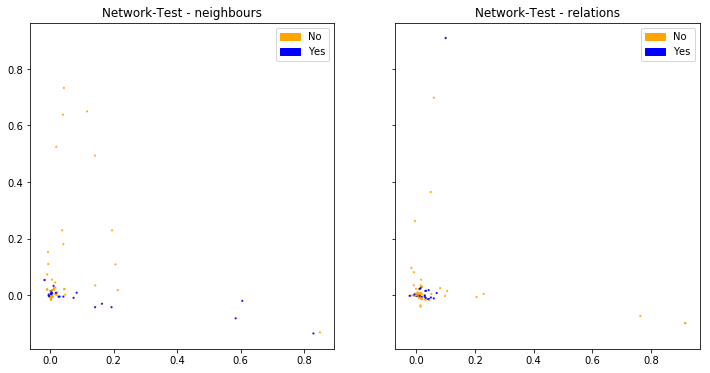

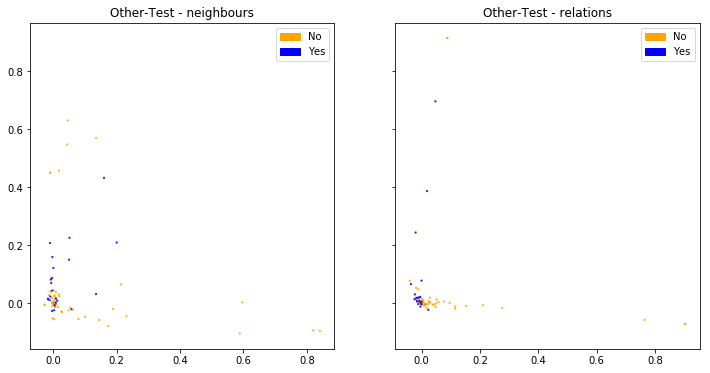

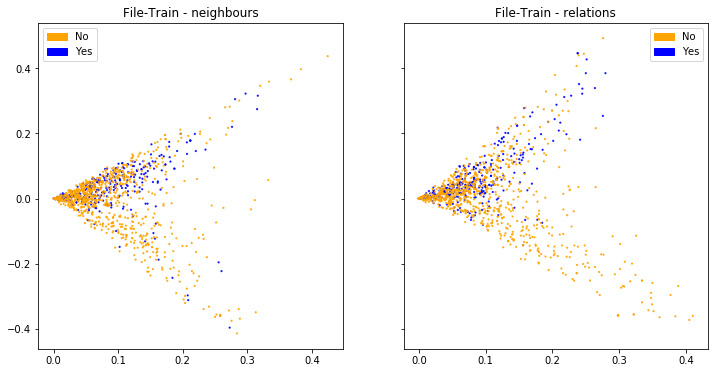

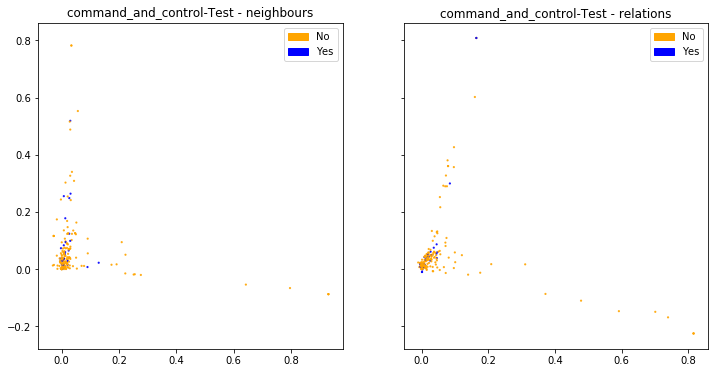

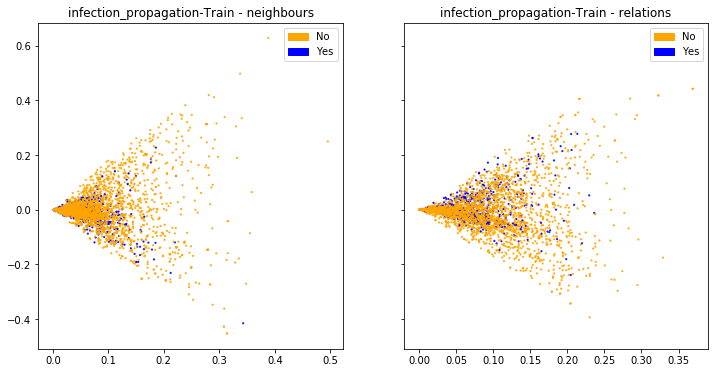

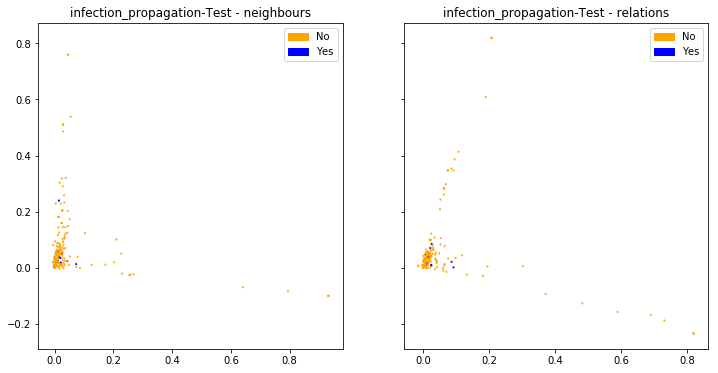

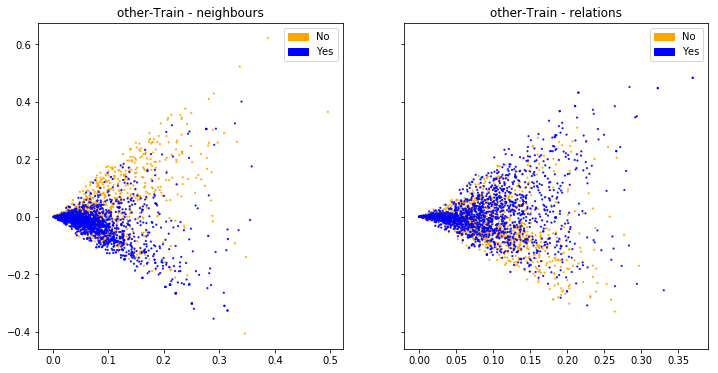

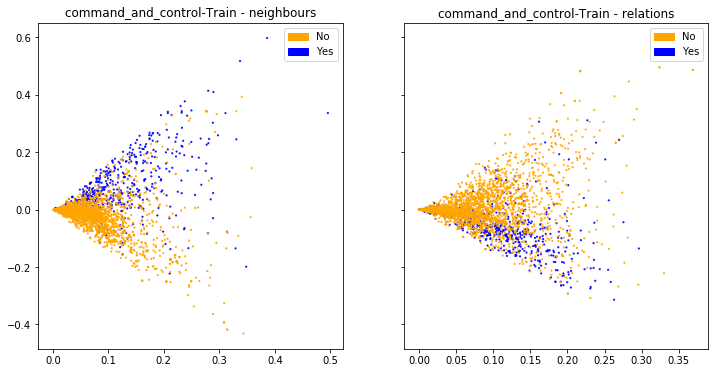

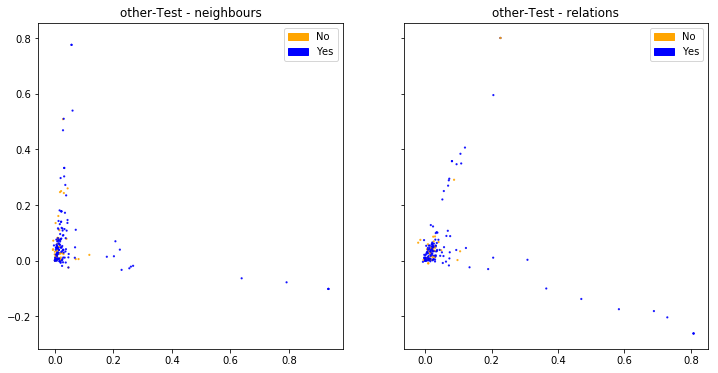

In [32]:
for cat in dataframes.keys():

    df = dataframes[cat]
    labels = df['label_num'].tolist()
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
    
    X_counts = vectorizer.fit_transform(df['text-neigh-tokens'])
    plot_LSA(X_counts, labels, ax1)
    ax1.set_title("{} - neighbours".format(cat))
    
    X_counts = vectorizer.fit_transform(df['text-rel-tokens'])
    plot_LSA(X_counts, labels, ax2)
    ax2.set_title("{} - relations".format(cat))

In [33]:
'''
Now for the n-grams! 
Are there bigrams more interesting for the classifier than unigrams?
'''

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    ngram_range=(1, 3)
)

'''
Let's search for bigrams, which position are they,
if we also take unigrams into consideration?

(COUNT VECTORIZER)
'''

for cat in dataframes.keys():
    print("\n>>> {}".format(cat))
    df = dataframes[cat]
    
    feature_count = 10 if 'Test' in cat else 100
    # because we expect nothing special from test dataset
    
    print("\nModel z relacjami:")
    X_counts = vectorizer.fit_transform(df['text-rel-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, feature_count, vectorizer, df)
    for entry in result:
        category = entry[0]
        print("-", category)
        words = entry[1]
        for idx, word in enumerate(words):
            len_check = len(word[0].split())
            if len_check > 1:
                print("{}. : {}, {}".format(idx, word[0], word[1]))
            
    
    print("\nModel 'sąsiedzi':")
    X_counts = vectorizer.fit_transform(df['text-neigh-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, feature_count, vectorizer, df)
    for entry in result:
        category = entry[0]
        print("-", category)
        words = entry[1]
        for idx, word in enumerate(words):
            len_check = len(word[0].split())
            if len_check > 1:
                print("{}. : {}, {}".format(idx, word[0], word[1]))


>>> Other-Train

Model z relacjami:
bag-of-words: 10238
- NoOther
45. : command control, 19.0
57. : execut file, 16.0
60. : c&c server, 16.0
73. : download file, 13.0
76. : ip address, 13.0
82. : control server, 12.0
98. : command control server, 10.0
- Other
26. : post request, 22.0
43. : registri key, 16.0
49. : get request, 14.0
53. : http post, 13.0
62. : system-path system-path, 11.0
70. : http post request, 10.0
74. : pipe server, 9.0
78. : name pipe, 9.0
80. : dll modul, 8.0
97. : network share, 7.0
98. : http get request, 7.0
99. : http get, 7.0

Model 'sąsiedzi':
bag-of-words: 9447
- NoOther
26. : download execut, 22.0
58. : execut file, 13.0
64. : upload download, 12.0
87. : disk execut, 9.0
97. : download file, 9.0
- Other
49. : post request, 11.0
55. : registri key, 10.0
61. : get request, 9.0
68. : driver hook, 8.0
71. : http post, 8.0
81. : dll modul, 7.0
96. : usermod dll, 6.0
97. : load dll, 6.0

>>> File-Test

Model z relacjami:
bag-of-words: 844
- File
4. : event log

KeyboardInterrupt: 

In [15]:
'''
Check scores considering n-grams for TDIDF Vectorizer!
'''

vectorizer = TfidfVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    ngram_range=(1,3)
)

for cat in dataframes.keys():
    print("\n>>> {}".format(cat))
    df = dataframes[cat]
    
    feature_count = 10 if 'Test' in cat else 100
    # because we expect nothing special from test dataset
    
    print("\nModel z relacjami:")
    X_counts = vectorizer.fit_transform(df['text-rel-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, feature_count, vectorizer, df)
    for entry in result:
        category = entry[0]
        print("-", category)
        words = entry[1]
        for idx, word in enumerate(words):
            len_check = len(word[0].split())
            if len_check > 1:
                print("{}. : {}, {}".format(idx, word[0], word[1]))
            
    
    print("\nModel 'sąsiedzi':")
    X_counts = vectorizer.fit_transform(df['text-neigh-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, feature_count, vectorizer, df)
    for entry in result:
        category = entry[0]
        print("-", category)
        words = entry[1]
        for idx, word in enumerate(words):
            len_check = len(word[0].split())
            if len_check > 1:
                print("{}. : {}, {}".format(idx, word[0], word[1]))


>>> ActionName-Train

Model z relacjami:
bag-of-words: 30775
- ActionName
47. : download file, 5.839672193343967
56. : execut file, 5.001764667127984
64. : post request, 4.601443536432968
69. : upload file, 4.3525977951713415
83. : command control, 3.727395518858263
92. : c&c server, 3.4038398288696743
- NoActionName
35. : c&c server, 9.282584717553169
41. : command control, 8.92652424556101
82. : attack use, 5.516364230587741
85. : ip address, 5.450388832132534

Model 'sąsiedzi':
bag-of-words: 25913
- ActionName
40. : download execut, 5.3181342086504815
88. : execut file, 3.164302576102987
92. : upload download, 3.049998721769038
- NoActionName
54. : c&c server, 6.728795838029409

>>> ActionName-Test

Model z relacjami:
bag-of-words: 2604
- ActionName
- NoActionName
4. : c&c server, 2.673775449766095

Model 'sąsiedzi':
bag-of-words: 2265
- ActionName
9. : download execut, 1.1457942846834346
- NoActionName
6. : c&c server, 1.9204115043608707

>>> Capability-Train

Model z relacjami:
b

In [57]:
'''
Saving processed data to file
'''

subfolder = 'Processed'
for ccat in dataframes.keys():
    sub_path = os.getcwd() + "/Dataframes/All/" + subfolder
    new_filename = '{}-P.csv'.format(ccat)
    if "label" in dataframes[ccat].columns:
        dataframes[ccat].drop(["label"], axis=1)
    dataframes[ccat]['ActionName_num'] = dataframes[ccat]['ActionName'].map({'-':0, 'File':1, 'Network':2, 'Other':3})
    dataframes[ccat]['Capability_num'] = dataframes[ccat]['Capability'].map({'-':0, 'command_and_control':1, 'infection_propagation':2, 'Other':3})
    dataframes[ccat].to_csv(sub_path + "/" + new_filename)


In [56]:
dataframes['All-Train'].drop(['label'], axis=1)

,Unnamed: 0,text-rel,token,ActionName,Capability,text-rel-processed,text-rel-tokens,ActionName_num,Capability_num
0,0,ScanBox performs keylogging of users when they...,performs,-,other,scanbox perform keylog user visit compromis we...,"[scanbox, perform, keylog, user, visit, compro...",0,NaN
1,1,an attacker perform reconnaissance and key log...,perform,-,other,attack perform reconnaiss key log visitor comp...,"[attack, perform, reconnaiss, key, log, visito...",0,NaN
2,2,tracking files and drives present on the victi...,tracking,-,other,track file drive present victim machin,"[track, file, drive, present, victim, machin]",0,NaN
3,3,it being a command and control destination for...,being,-,command_and_control,command control destin malwar,"[command, control, destin, malwar]",0,1.0
4,4,the e-mails contain links to websites hosting ...,contain,-,infection_propagation,e-mail contain link websit host scanbox,"[e-mail, contain, link, websit, host, scanbox]",0,2.0
5,5,Both backdoors were dropped from malicious doc...,were dropped,Network,other,backdoor drop malici document built util tran ...,"[backdoor, drop, malici, document, built, util...",2,NaN
6,6,backdoor HTTP communicates via to a hard-coded...,communicates,-,other,backdoor http commun via hard-cod command cont...,"[backdoor, http, commun, via, hard-cod, comman...",0,NaN
7,7,this change decrease detection,decrease,-,other,thi chang decreas detect,"[thi, chang, decreas, detect]",0,NaN
8,8,sent a spear phish email to a Taiwanese govern...,sent,Network,infection_propagation,sent spear phish email taiwanes govern ministri,"[sent, spear, phish, email, taiwanes, govern, ...",2,2.0
9,9,The exploit document dropped the HIGHTIDE back...,dropped,-,-,exploit document drop hightid backdoor,"[exploit, document, drop, hightid, backdoor]",0,0.0
